In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE



In [3]:
# Step 1: Load the dataset
data = pd.read_csv('Leads.csv')

# Step 2: Data Cleaning
# Remove columns with 'Select' values as they are equivalent to null values
data = data.replace('Select', np.nan)

# Handle missing values (drop columns/rows with excessive null values or impute appropriately)
data = data.dropna()

# Step 3: Encode Categorical Variables
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Step 4: Feature Selection
# Define independent variables (X) and target variable (y)
X = data.drop('Converted', axis=1)
y = data['Converted']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Use Recursive Feature Elimination (RFE) with Logistic Regression
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=10)  # Select top 10 features
rfe.fit(X_scaled, y)

# Get top features
selected_features = X.columns[rfe.support_]
print("Top Selected Features:", selected_features)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Step 6: Model Training
logreg.fit(X_train, y_train)

# Step 7: Evaluate the Model
# Predictions and metrics
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

Top Selected Features: Index(['Total Time Spent on Website', 'Asymmetrique Activity Score',
       'Prospect ID_6f93b685-df54-47c8-b0c6-11f11e6d902e',
       'How did you hear about X Education_Online Search',
       'Tags_Closed by Horizzon', 'Tags_Interested  in full time MBA',
       'Tags_Interested in other courses',
       'Tags_Will revert after reading the email', 'Lead Quality_Not Sure',
       'Lead Quality_Worst'],
      dtype='object')


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        24
           1       0.93      0.97      0.95        66

    accuracy                           0.92        90
   macro avg       0.92      0.88      0.90        90
weighted avg       0.92      0.92      0.92        90

Confusion Matrix:
 [[19  5]
 [ 2 64]]
ROC-AUC Score: 0.9507575757575758


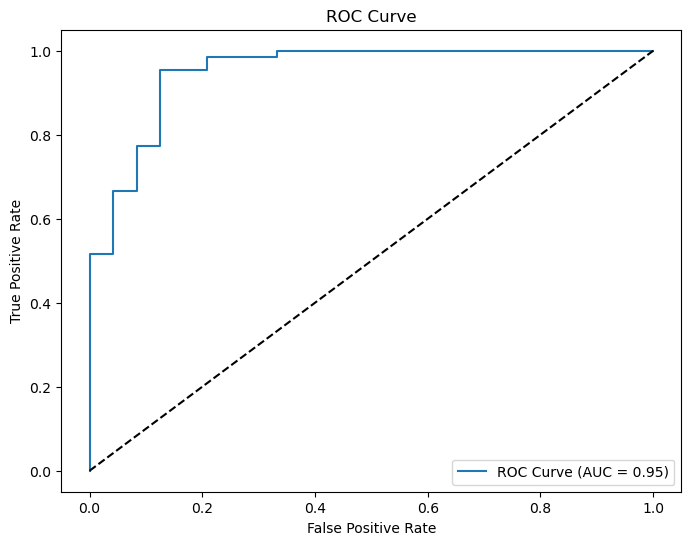

In [5]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC-AUC
roc_score = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_score)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [6]:
# Step 8: Analyze Coefficients for Categorical Variables
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
})

# Sort by absolute value of coefficients
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Top 3 numerical features
print("Top 3 Numerical Features:\n", coefficients.head(3))

# Top 3 categorical/dummy variables
categorical_features = coefficients[coefficients['Feature'].str.contains('_')]
print("Top 3 Categorical/Dummy Features:\n", categorical_features.head(3))

# Step 9: Strategies
# During aggressive periods, adjust threshold for recall
# During reduced-focus periods, adjust threshold for precision
thresholds = np.arange(0.1, 0.9, 0.1)
precision_recall_data = []


Top 3 Numerical Features:
                                       Feature  Coefficient  Abs_Coefficient
360  Tags_Will revert after reading the email     0.662495         0.662495
354          Tags_Interested in other courses    -0.615503         0.615503
2                 Total Time Spent on Website     0.600335         0.600335
Top 3 Categorical/Dummy Features:
                                       Feature  Coefficient  Abs_Coefficient
360  Tags_Will revert after reading the email     0.662495         0.662495
354          Tags_Interested in other courses    -0.615503         0.615503
368                        Lead Quality_Worst    -0.436387         0.436387


In [7]:
for threshold in thresholds:
    y_pred_custom = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    precision_recall_data.append((threshold, precision, recall))

precision_recall_df = pd.DataFrame(precision_recall_data, columns=['Threshold', 'Precision', 'Recall'])
print(precision_recall_df)

   Threshold  Precision    Recall
0        0.1   0.825000  1.000000
1        0.2   0.857143  1.000000
2        0.3   0.880000  1.000000
3        0.4   0.902778  0.984848
4        0.5   0.927536  0.969697
5        0.6   0.926471  0.954545
6        0.7   0.954545  0.954545
7        0.8   0.953125  0.924242
